## Model definition

See https://en.wikipedia.org/wiki/Lorenz_system

In [1]:
using Reachability, MathematicalSystems, TaylorIntegration

┌ Info: Recompiling stale cache file /Users/sebastianguadalupe/.julia/compiled/v1.2/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1240


In [2]:
@taylorize function lorenz!(dx, x, params, t)
    local σ = 10.0
    local β = 8.0 / 3.0
    local ρ = 28.0
    dx[1] = σ * (x[2] - x[1])
    dx[2] = x[1] * (ρ - x[3]) - x[2]
    dx[3] = x[1] * x[2] - β * x[3]
    return dx
end

𝑆 = BlackBoxContinuousSystem(lorenz!, 3)
X0 = Hyperrectangle(low=[0.9, 0.0, 0.0], high=[1.1, 0.0, 0.0])
𝑃 = InitialValueProblem(𝑆, X0);

## Solution using TMJets algorithm

In [50]:
# compute the flowpipe
𝑂 = Options(:T=>10.0, :mode=>"reach")
sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-27, :orderT=>10, :orderQ=>2, :max_steps=>50_000));

In [4]:
@time sol = solve(𝑃, 𝑂, op=TMJets(:abs_tol=>1e-27, :orderT=>10, :orderQ=>2, :max_steps=>50_000));

138.520890 seconds (1.09 G allocations: 66.138 GiB, 31.68% gc time)


## Plots

In [5]:
typeof(sol.Xk) # contains the flowpipe

Array{ReachSet{Hyperrectangle{Float64,StaticArrays.SArray{Tuple{3},Float64,1,3},StaticArrays.SArray{Tuple{3},Float64,1,3}}},1}

In [4]:
using Plots

┌ Info: Recompiling stale cache file /Users/sebastianguadalupe/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


In [23]:
dim(set(sol.Xk[1])) # the reachsets speaks about coordinates x, y and z

3

### Plot x(t)

In [13]:
sol.options[:plot_vars] = [0, 1] # plot x(t) vs t
sol_proj = project(sol); # project onto :plot_vars variables

In [14]:
N = length(sol_proj.Xk) # number of computed sets

44572

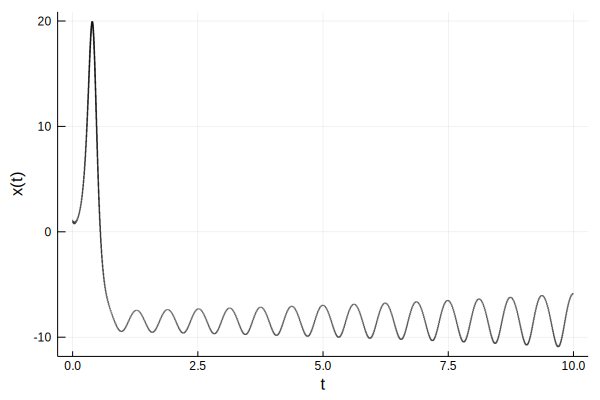

In [15]:
plot([set(sol_proj.Xk[i]) for i=1:50:N], color=:lightblue, xlab="t", ylab="x(t)")

### Plot y(t)

In [31]:
sol.options[:plot_vars] = [0, 2] # plot y(t) vs t
sol_proj = project(sol); # project onto :plot_vars variables

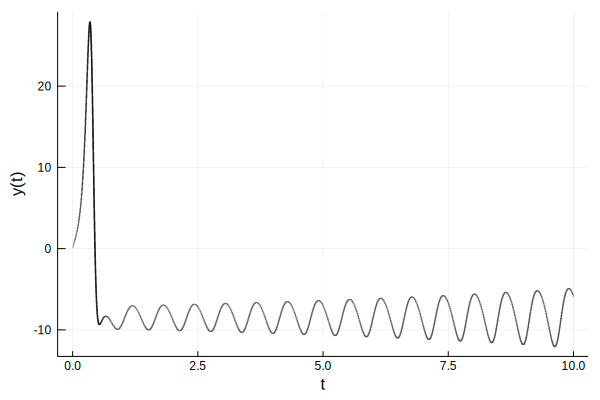

In [32]:
plot([set(sol_proj.Xk[i]) for i=1:50:N], color=:lightblue, xlab="t", ylab="y(t)")

### Plot z(t)

In [33]:
sol.options[:plot_vars] = [0, 3] # plot z(t) vs t
sol_proj = project(sol); # project onto :plot_vars variables

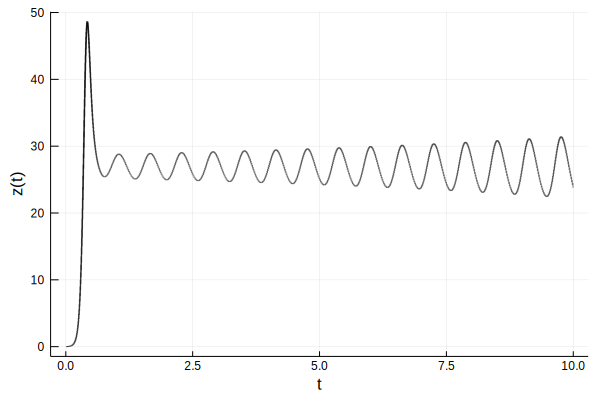

In [34]:
plot([set(sol_proj.Xk[i]) for i=1:50:N], color=:lightblue, xlab="t", ylab="z(t)")

### Plot x(t) vs y(t)

In [35]:
sol.options[:plot_vars] = [1, 2] # plot x(t) vs y(t)
sol_proj = project(sol); # project onto :plot_vars variables

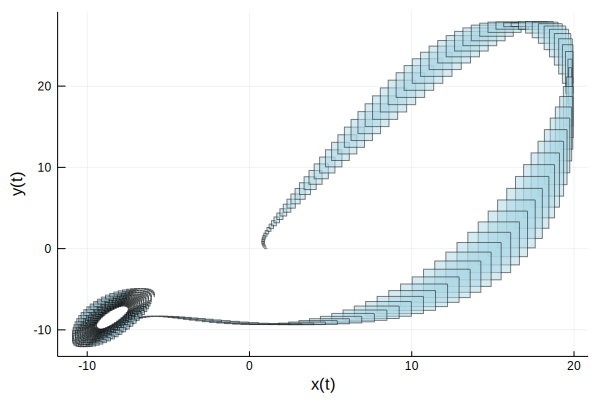

In [32]:
plot([set(sol_proj.Xk[i]) for i=1:50:N], color=:lightblue, xlab="x(t)", ylab="y(t)")

## Solution of one trajectory

Here we solve the trajectory corresponding to the center of our initial states using
DifferentialEquations.jl.

In [33]:
LazySets.center(X0)

3-element Array{Float64,1}:
 1.0
 0.0
 0.0

┌ Info: Recompiling stale cache file /Users/sebastianguadalupe/.julia/compiled/v1.2/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1240


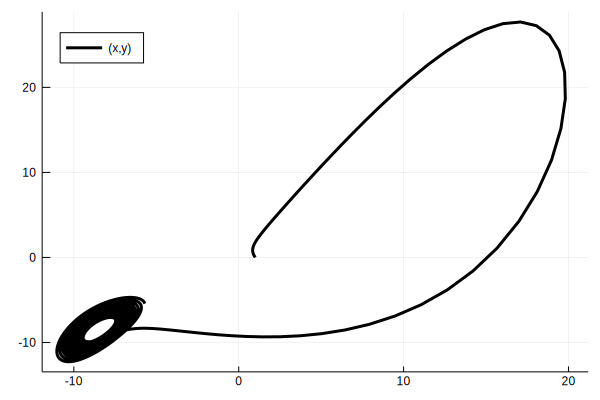

In [5]:
using DifferentialEquations, ParameterizedFunctions, Plots

lorenz = @ode_def begin                  # define the system
 dx = σ * (y - x)
 dy = x * (ρ - z) - y
 dz = x * y - β*z
end σ ρ β

u0 = [1.0,0.0,0.0]                       # initial conditions
tspan = (0.0,10.0)                       # timespan
p = [10.0, 28.0, 8/3]                    # parameters
prob = ODEProblem(lorenz, u0, tspan, p)  # define the problem
nsol = DifferentialEquations.solve(prob)  # solve it using default tolerances
plot(nsol, vars = (1, 2), color=:black, legend=:topleft)   # plot solution in phase space - variables ordered with 1 based indexing

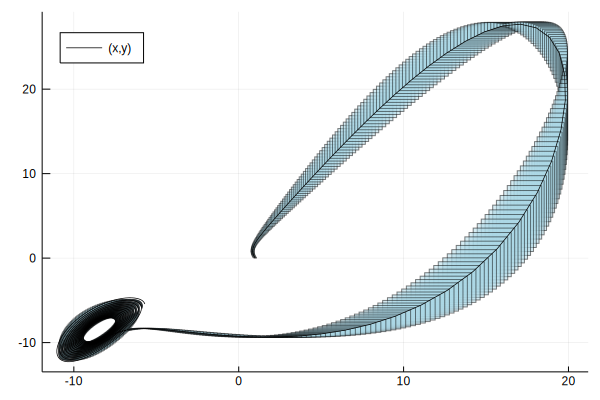

In [46]:
sol.options[:plot_vars] = [0, 1]
plot([set(sol_proj.Xk[i]) for i=1:20:N], color=:lightblue) # flowpipe
plot!(nsol, vars = (1, 2), color=:black, linewidth=0.75, legend=:topleft) # trajectory

We observe that the numerical integration gets out of the computed flowpipe. This should be fixed by decreasing the tolerances of the numerical simulation.

### Plot closer to the attractor

We use the default algorithm, `Tsit5()`, a certain [explicit Runge-Kutta method](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#Explicit-Runge-Kutta-Methods-1).

We notice that the trajectory is outside the flowpipe. Below we use another algorithm with more precision and confirm that the trajectory gets *inside* de flowpipe. as expected.

In [23]:
u1 = LazySets.center(set(sol.Xk[20000]))
tspan1 = (0.0, 5.5)
prob = ODEProblem(lorenz, u1, tspan1, p)  # define the problem
nsol2 = DifferentialEquations.solve(prob);  # solve it using default tolerances

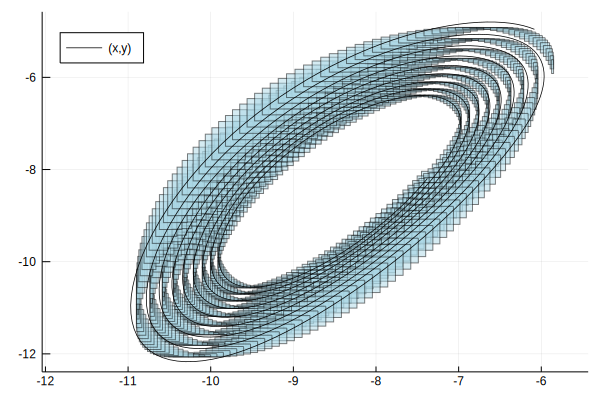

In [45]:
plot([set(sol_proj.Xk[i]) for i=20_000:20:N], color=:lightblue) # flowpipe
plot!(nsol2, vars = (1, 2), color=:black, linewidth=0.75, legend=:topleft) # trajectory

### Using Vern7

Here we use `Vern7()`, an explicit Runge-Kutta method with lazy interpolant, see (here)[http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#Explicit-Runge-Kutta-Methods-1]. The tolerances are the default ones.

In [29]:
vern_sol = DifferentialEquations.solve(prob, Vern7());

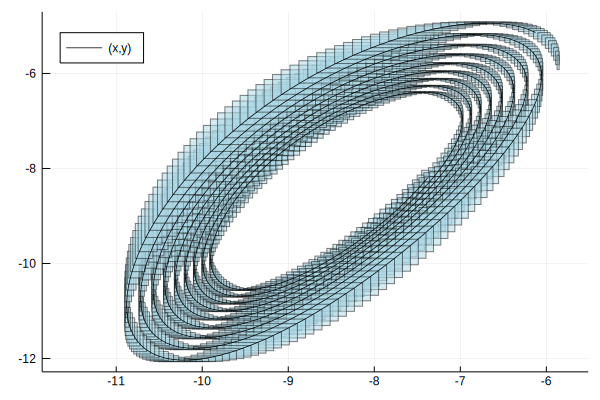

In [47]:
plot([set(sol_proj.Xk[i]) for i=20_000:20:N], color=:lightblue) # flowpipe
plot!(vern_sol, vars = (1, 2), color=:black, linewidth=0.75, legend=:topleft) # trajectory using Vern7

### Using Taylor series method

Here we use `TaylorIntegration.jl`, a pure-Julia implementation of an adaptive order Taylor series method for high accuracy integration of ODEs, see [here](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#TaylorIntegration.jl-1).

In [26]:
using TaylorIntegration

In [27]:
ti_sol = DifferentialEquations.solve(prob, TaylorMethod(4));

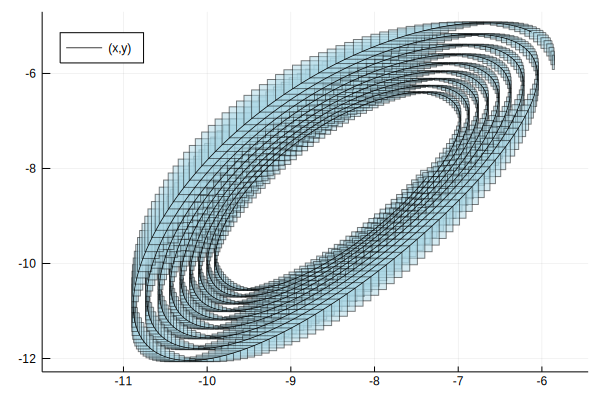

In [48]:
plot([set(sol_proj.Xk[i]) for i=20_000:20:N], color=:lightblue) # flowpipe
plot!(ti_sol, vars = (1, 2), color=:black, linewidth=0.75, legend=:topleft) # trajectory using TaylorIntegration